In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    root="./mnistdata", train=True, transform=transform, download=True
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="./mnistdata", train=False, transform=transform, download=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2996142.54it/s]


Extracting ./mnistdata/MNIST/raw/train-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1742458.20it/s]

Extracting ./mnistdata/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9328918.88it/s]


Extracting ./mnistdata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnistdata/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9709749.63it/s]

Extracting ./mnistdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnistdata/MNIST/raw



In [ ]:
train_dataset[1000][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_dataset[5000][1]

7

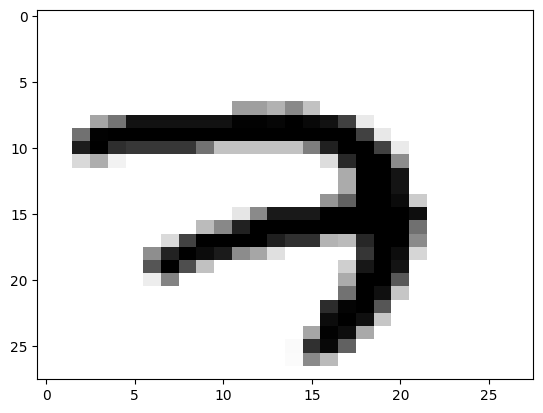

In [ ]:
fig = plt.figure()
plt.imshow(train_dataset[5000][0][0].numpy(), cmap="binary", aspect="auto")
plt.show()
plt.close(fig)

In [ ]:
class FCN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()

        self.layers = layers

        self.activation = torch.nn.ReLU()
        # self.activation = torch.nn.Tanh()
        self.last_layer_activation = torch.nn.Sigmoid()
        # self.last_layer_activation = torch.nn.Softmax()
        # self.loss_function = torch.nn.MSELoss(reduction="mean")
        self.loss_function = torch.nn.CrossEntropyLoss()

        self.linears = torch.nn.ModuleList(
            [
                torch.nn.Linear(self.layers[i], self.layers[i + 1])
                for i in range(len(self.layers) - 1)
            ]
        )
        for linear in self.linears:
            torch.nn.init.xavier_normal_(linear.weight.data)
            torch.nn.init.zeros_(linear.bias.data)

    def forward(self, x):
        h = torch.nn.Flatten()(x)
        for layer in self.linears[:-1]:
            z = layer(h)
            h = self.activation(z)
        y = self.last_layer_activation(self.linears[-1](h))
        return y

In [ ]:
model = FCN([28 * 28, 128, 64, 10]).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5

losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs)
        loss = model.loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i:3d}, Loss {loss.item():.3f}")
    losses.append(epoch_loss / len(train_loader))
    print(f"{'-' * 30}")
    print(f"Epoch {epoch + 1}, Epoch Loss {losses[-1]:.3f}")
    print(f"{'-' * 30}")

Epoch 1, Batch   0, Loss 2.331
Epoch 1, Batch 100, Loss 1.606
Epoch 1, Batch 200, Loss 1.576
Epoch 1, Batch 300, Loss 1.571
Epoch 1, Batch 400, Loss 1.544
Epoch 1, Batch 500, Loss 1.603
Epoch 1, Batch 600, Loss 1.541
Epoch 1, Batch 700, Loss 1.508
Epoch 1, Batch 800, Loss 1.569
Epoch 1, Batch 900, Loss 1.521
------------------------------
Epoch 1, Epoch Loss 1.588
------------------------------
Epoch 2, Batch   0, Loss 1.539
Epoch 2, Batch 100, Loss 1.508
Epoch 2, Batch 200, Loss 1.520
Epoch 2, Batch 300, Loss 1.554
Epoch 2, Batch 400, Loss 1.499
Epoch 2, Batch 500, Loss 1.535
Epoch 2, Batch 600, Loss 1.534
Epoch 2, Batch 700, Loss 1.546
Epoch 2, Batch 800, Loss 1.546
Epoch 2, Batch 900, Loss 1.537
------------------------------
Epoch 2, Epoch Loss 1.524
------------------------------
Epoch 3, Batch   0, Loss 1.508
Epoch 3, Batch 100, Loss 1.520
Epoch 3, Batch 200, Loss 1.519
Epoch 3, Batch 300, Loss 1.519
Epoch 3, Batch 400, Loss 1.518
Epoch 3, Batch 500, Loss 1.502
Epoch 3, Batch 600

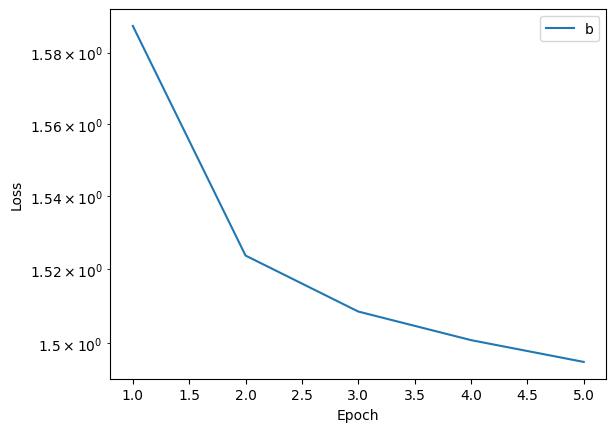

In [ ]:
fig = plt.figure()
plt.plot(range(1, num_epochs + 1), losses, label="Training Loss")
plt.legend("best")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
plt.close(fig)

In [ ]:
with torch.inference_mode():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 95.84%


In [ ]:
nb_classes = 10

pred_list = torch.empty(0)
label_list = torch.empty(0)

with torch.inference_mode():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)

        outputs = model(inputs).cpu()

        _, preds = torch.max(outputs, 1)

        pred_list = torch.cat([pred_list, preds.view(-1)])
        label_list = torch.cat([label_list, classes.view(-1)])

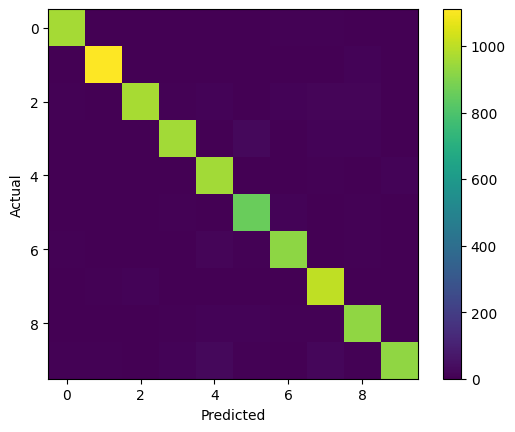

In [ ]:
conf_mat = confusion_matrix(label_list.numpy(), pred_list.numpy())
fig, _ = plt.subplots()
plt.imshow(conf_mat)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
plt.close(fig)

In [ ]:
class_accuracy = conf_mat.diagonal() / conf_mat.sum(1)
for i in range(10):
    print(f"{class_accuracy[i]:.2f}")

0.98
0.98
0.93
0.95
0.98
0.96
0.96
0.98
0.95
0.92


In [ ]:
class_report = classification_report(pred_list.numpy(), label_list.numpy())
print(class_report)

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       989
         1.0       0.98      0.98      0.98      1135
         2.0       0.93      0.98      0.96       983
         3.0       0.95      0.97      0.96       987
         4.0       0.98      0.94      0.96      1023
         5.0       0.96      0.94      0.95       911
         6.0       0.96      0.96      0.96       962
         7.0       0.98      0.93      0.96      1075
         8.0       0.95      0.93      0.94       992
         9.0       0.92      0.98      0.95       943

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

